In [6]:
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time
from GP_Classes import GaussianProcess, SparseGaussianProcess
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import jax.numpy as jnp

In [7]:
def estimate_memory_usage(n_samples, n_features, model_type, n_inducing=None):
    # Memory for dataset (X_train and y_train)
    dataset_memory = n_samples * n_features * 8 + n_samples * 8  # X_train + y_train (float64, 8 bytes per float)
    if model_type == "GPR":
        # Covariance matrix is N x N
        covariance_matrix_memory = n_samples ** 2 * 8  # N x N matrix, 8 bytes per float
    elif model_type == "SGPR":
        # Covariance matrix is M x M (inducing points)
        if n_inducing is None:
            raise ValueError("n_inducing must be provided for SGPR")
        covariance_matrix_memory = n_inducing ** 2 * 8  # M x M matrix, 8 bytes per float
        
    # Memory for kernel parameters and gradients (assume around 1 KB for kernel + gradients)
    kernel_and_gradients_memory = 1024 

    # Total memory usage estimate
    total_memory = dataset_memory + covariance_matrix_memory + kernel_and_gradients_memory

    return total_memory / (1024 ** 2) 


In [8]:
# Function for farthest point sampling to select inducing points
def farthest_point_sampling(X, n_inducing_points):
    
    # Start by selecting a random point from X as the first inducing point
    Z = [X[np.random.choice(len(X))]]
    
    # Iteratively select the farthest point from the set Z and and to the set
    for _ in range(n_inducing_points - 1):
        dists = jnp.min(jnp.array([jnp.linalg.norm(X - z, axis=1) for z in Z]), axis=0)
        next_point = X[jnp.argmax(dists)]
        Z.append(next_point)
    
    return jnp.array(Z)

# Function to train a GP model and return the RMSE, average uncertainty, time taken, and iteration count
def train_and_evaluate_gp(n_samples, model, optim_method):
    # Generate synthetic regression data
    X, y = make_regression(n_samples=n_samples, n_features=1, noise=1, random_state=0)  # n_features=1 for plotting
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Optimize the model's parameters with a callback to count iterations
    if model == "GPR":
        model = GaussianProcess(X_train, y_train, optim_method)
    if model == "SGPR":
        n_inducing_points = int(len(X_train)*0.1)  # or any other number less than n_points
        # Z_train = X_train[np.random.choice(len(X_train), n_inducing_points, replace=False)]
        Z_train = farthest_point_sampling(X_train, n_inducing_points)
        model = SparseGaussianProcess(X_train, y_train,Z_train, optim_method)
    
    # Measure the time taken to optimize (which includes matrix inversion)
    start_time = time.time()
    noise = model.fit()
    end_time = time.time()
    
    # Time taken for matrix inversion and optimization
    time_taken = end_time - start_time
    
    # Make predictions on the test set
    means, variances = zip(*(model.predict(x.reshape(-1, 1)) for x in X_test))

    # Compute RMSE
    rmse = np.sqrt(np.mean((np.array(means) - y_test) ** 2))
    avg_uncertantiy = np.mean(np.sqrt(np.array(variances)))
    
    # Calculate the lower and upper bounds of the confidence interval
    lower_bound = means - 1.96 * np.sqrt(variances)
    upper_bound = means + 1.96 * np.sqrt(variances)
    # Check if y_test is within the confidence interval bounds
    uncertainties = np.where((lower_bound <= y_test) & (y_test <= upper_bound), 1, 0)
    in_interval = np.mean(uncertainties)

    return rmse, avg_uncertantiy, time_taken, noise, in_interval

In [9]:
# General function to run comparison for multiple GP models
def run_comparison(max_samples, models_kernels):
    df = pd.DataFrame(columns=['Model', 'RMSE', 'Dataset Size', 'Time', 'Memory Usage', 'Avg Uncertainty', 'Predictive Noise', 'In Interval'])
    start = 10
    step = 10
    dataset_sizes = np.arange(start, max_samples + 1, step)

    # Dictionary to store results for each model
    results = {
        'loss_history': {},
        'times': {},
        'uncertainties': {},
        'memory_usages': {},
    }

    # Loop over each model and its kernel
    for model_name, optim_method in models_kernels:
        loss_history = []
        times = []
        uncertainties = []  
        memory_usages = []
        
        for idx, size in enumerate(dataset_sizes):
            rmse, avg_uncertantiy, time_taken, pred_noise, in_interval = train_and_evaluate_gp(size, model_name, optim_method)
            loss_history.append(rmse)
            memory = estimate_memory_usage(n_samples=size, n_features=1, model_type=model_name, n_inducing=0.1*size)
            uncertainties.append(avg_uncertantiy)
            times.append(time_taken)
            memory_usages.append(memory)
            name = model_name + " " + optim_method
            print(f"Model: {name}, Dataset size: {size}, Time: {time_taken:.4f} seconds, "
                  f"Memory: {memory:.2f} MB,"
                  f"Uncertainty: {avg_uncertantiy:.4f}")
            
            # Update dataframe
            new_row = pd.DataFrame({
                'Model': name,
                'Dataset Size': size,
                'RMSE': rmse,
                'Time': time_taken,
                'Memory Usage': memory,
                'Avg Uncertainty': avg_uncertantiy,
                'Predictive Noise': pred_noise,
                'In Interval': in_interval,
            }, index=[0])    

            df = pd.concat([df, new_row], ignore_index=True)
        
        # Store results for this model
        results['times'][name] = times
        results['uncertainties'][name] = uncertainties
        results['memory_usages'][name] = memory_usages
        results['loss_history'][name] = loss_history
    # Plotting the results

    df.to_csv('results_albin.csv')
    plt.figure(figsize=(10, 12))

    plt.subplot(4, 1, 1)
    for name in results['loss_history']:
        plt.plot(dataset_sizes, results['loss_history'][name], 'o-', label=f'{name} Loss')
    plt.title('Performance Metrics vs Dataset Size')
    plt.ylabel('Loss (RMSE)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()
    
    # Time Plot
    plt.subplot(4, 1, 2)
    for name in results['times']:
        plt.plot(dataset_sizes, results['times'][name], 'o-', label=f'{name} Time')
    plt.title('Performance Metrics vs Dataset Size')
    plt.ylabel('Time (seconds)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Memory Usage Plot
    plt.subplot(4, 1, 3)
    for name in results['memory_usages']:
        plt.plot(dataset_sizes, results['memory_usages'][name], 'o-', label=f'{name} Memory Usage')
    plt.ylabel('Memory Usage (MB)')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    # Uncertainty Plot
    plt.subplot(4, 1, 4)
    for name in results['uncertainties']:
        plt.plot(dataset_sizes, results['uncertainties'][name], 'o-', label=f'{name} Avg. Uncertainty')
    plt.ylabel('Uncertainty')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

NLL after optimization L-BFGS-B: 8299.263
Model: GPR L-BFGS-B, Dataset size: 10, Time: 0.1328 seconds, Memory: 0.00 MB,Uncertainty: 0.0234


/var/folders/vk/1m8ycy4d2ysfq7vh0rdx92780000gn/T/ipykernel_24986/725748364.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


NLL after optimization L-BFGS-B: 260.3733
Model: GPR L-BFGS-B, Dataset size: 20, Time: 0.7588 seconds, Memory: 0.00 MB,Uncertainty: 1.0480
NLL after optimization L-BFGS-B: 42450.523
Model: GPR L-BFGS-B, Dataset size: 30, Time: 1.4675 seconds, Memory: 0.01 MB,Uncertainty: 0.0491
NLL after optimization L-BFGS-B: 2587.2644
Model: GPR L-BFGS-B, Dataset size: 40, Time: 2.2148 seconds, Memory: 0.01 MB,Uncertainty: 0.0104
NLL after optimization L-BFGS-B: 1097.7192
Model: GPR L-BFGS-B, Dataset size: 50, Time: 3.2640 seconds, Memory: 0.02 MB,Uncertainty: 0.0096
NLL after optimization L-BFGS-B: 2829.856
Model: GPR L-BFGS-B, Dataset size: 60, Time: 4.5605 seconds, Memory: 0.03 MB,Uncertainty: 0.0121
NLL after optimization L-BFGS-B: 13231.269
Model: GPR L-BFGS-B, Dataset size: 70, Time: 6.1370 seconds, Memory: 0.04 MB,Uncertainty: 0.0130
NLL after optimization L-BFGS-B: 52161.54
Model: GPR L-BFGS-B, Dataset size: 80, Time: 7.7884 seconds, Memory: 0.05 MB,Uncertainty: 0.0098
NLL after optimization 

2024-11-07 23:24:53.031068: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_negative_log_likelihood] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-11-07 23:25:22.942624: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m29.922289s

********************************
[Compiling module jit_negative_log_likelihood] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Terminating on step size tolerance
Termination criterion met on iteration 0
NLL after optimization ADAM: 17916.668
Parameter History:
Model: GPR ADAM, Dataset size: 110, Time: 1810.8778 seconds, Memory: 0.09 MB,Uncertainty: 0.0838


2024-11-08 00:13:06.807385: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 3m34.956237s

********************************
[Compiling module jit_negative_log_likelihood] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Terminating on step size tolerance
Termination criterion met on iteration 0
NLL after optimization ADAM: 445.03418
Parameter History:
Model: GPR ADAM, Dataset size: 120, Time: 2820.0357 seconds, Memory: 0.11 MB,Uncertainty: 0.0834


2024-11-08 01:26:09.712193: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 5m8.206421s

********************************
[Compiling module jit_negative_log_likelihood] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Terminating on step size tolerance
Termination criterion met on iteration 0
NLL after optimization ADAM: 44499.934
Parameter History:
Model: GPR ADAM, Dataset size: 130, Time: 4330.4393 seconds, Memory: 0.13 MB,Uncertainty: 0.0821
Time budget exceeded ADAM.
Parameter History:
Model: SGPR ADAM, Dataset size: 10, Time: 10.0399 seconds, Memory: 0.00 MB,Uncertainty: 1.7847
Time budget exceeded ADAM.
Parameter History:
Model: SGPR ADAM, Dataset size: 20, Time: 10.0770 seconds, Memory: 0.00 MB,Uncertainty: 1.9053
Time budget exceeded ADAM.
Parameter History:
Model: SGPR ADAM, Dataset size: 30, Time: 10.1732 seconds, Memory: 0.00 MB,Uncertainty: 1.5811
Time budget exceeded ADAM.
Parameter History:
Model: SGPR ADAM, Dataset size: 40, Time: 10.2836 seconds, Memory: 0.00 MB,Uncertainty: 1.5500
Time budget exceeded ADAM.
Parameter History:
Model: SGPR ADAM, Dataset size: 50, Time: 10.4469 seconds, Memory: 0.00 MB,Uncertainty: 1.1868
Time budget exceeded ADAM.
Parameter History:
Model: SGPR ADAM, 

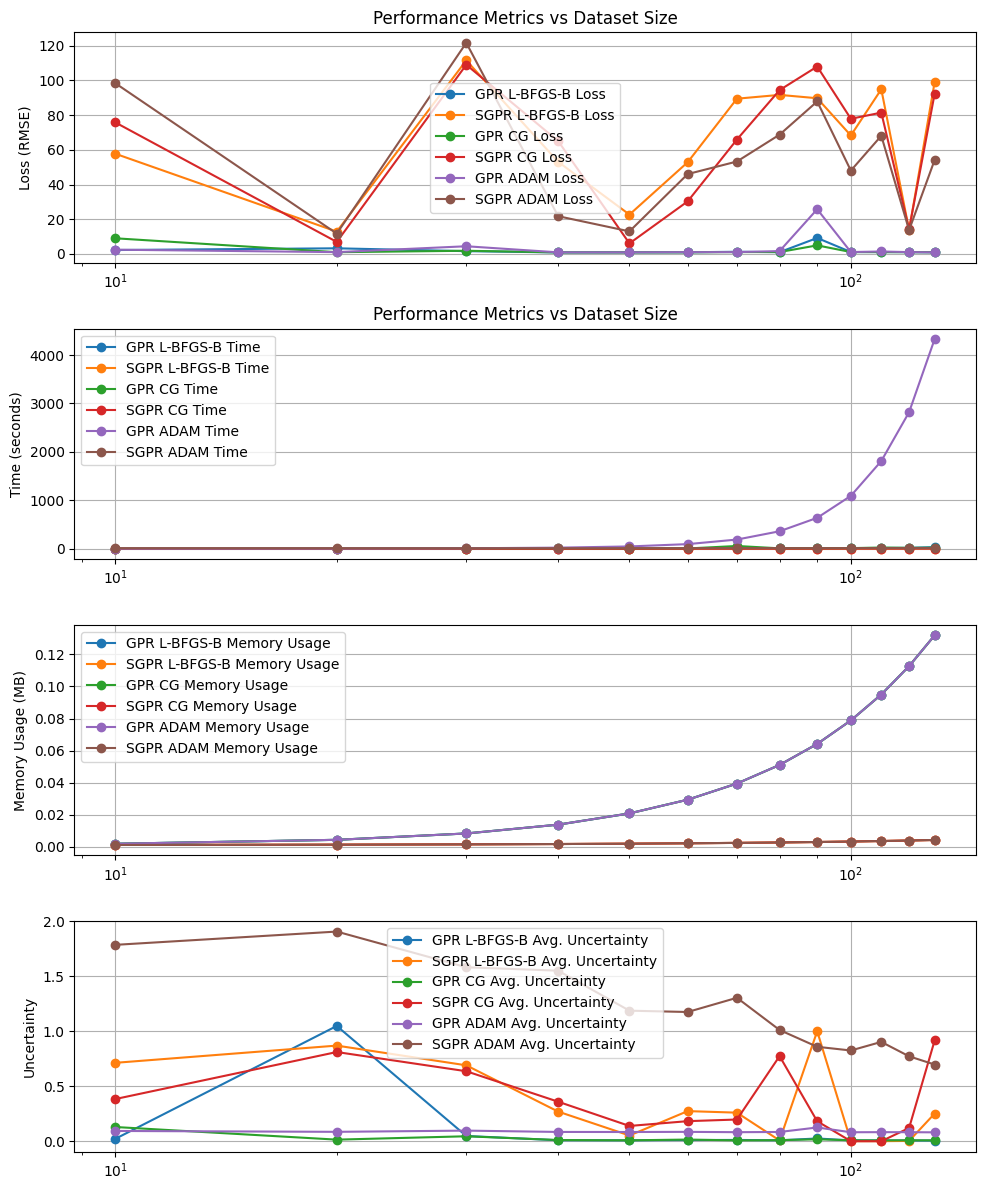

{'loss_history': {'GPR L-BFGS-B': [2.242184462317076,
   3.2387152158382255,
   1.594560433027091,
   0.8514216907050259,
   0.8970176398671206,
   0.954277230673966,
   1.2370857202502352,
   1.0198681112130135,
   9.19007911295881,
   1.0774060039482884,
   1.0648349799624255,
   1.0262575310130353,
   0.92357535109879],
  'SGPR L-BFGS-B': [57.72163996736385,
   12.855714791738498,
   111.52771916830191,
   53.06012127801238,
   22.669694196393845,
   52.84758734718081,
   89.45295120518803,
   91.64592490762004,
   89.71736454307037,
   68.24821875041188,
   94.87897852269445,
   13.777902754384943,
   99.08697350464962],
  'GPR CG': [9.007303370148737,
   0.9966005235228114,
   1.8224424339964695,
   0.889045866595144,
   0.8969701530867031,
   0.9231595847743747,
   1.0693739323050955,
   1.0894895971355094,
   4.927307972034493,
   1.0854840774451595,
   1.0650108913789817,
   1.012297297026022,
   1.0152105188725287],
  'SGPR CG': [75.76439504974952,
   6.914648815839255,
   109

In [10]:
models_kernels = [
    ("GPR", "L-BFGS-B"),
    ("SGPR", "L-BFGS-B"),
    ("GPR", "CG"),
    ("SGPR", "CG"),
    ("GPR", "ADAM"),
    ("SGPR", "ADAM"),
]
# Run the comparison for these models
run_comparison(max_samples=130, models_kernels=models_kernels)